# Trabajo Semanal Nº9 : Laboratorio de Filtros digitales
Curso: R4052  
Profesor: Mariano Llamedo Soria  
Ayudante de TPs: David Moharos  

Alumno: Rodríguez Silvosa, Martín

### Inicialización del entorno de trabajo:

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

# Tamaño de las figuras
fig_sz_x = 14
fig_sz_y = 7

# Tamaño de la tipografía
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

### Plantilla de diseño:

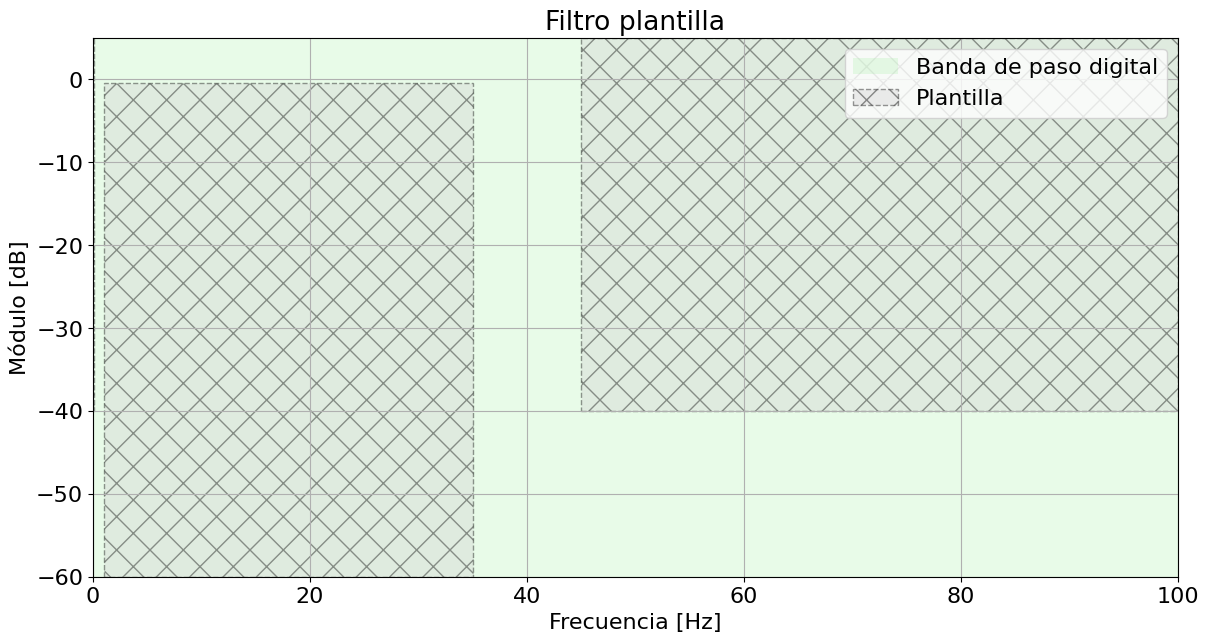

In [12]:
# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = .1 #Hz
wp1 = 1 #Hz
wp2 = 35.0 #Hz
ws2 = 45.0 #Hz

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)


plt.title('Filtro plantilla')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
_ = plt.legend()

#### Tendré que diseñar un filtro IIR y un filtro FIR que cumplan con los requisitos de la plantilla

### Diseño del filtro IIR:

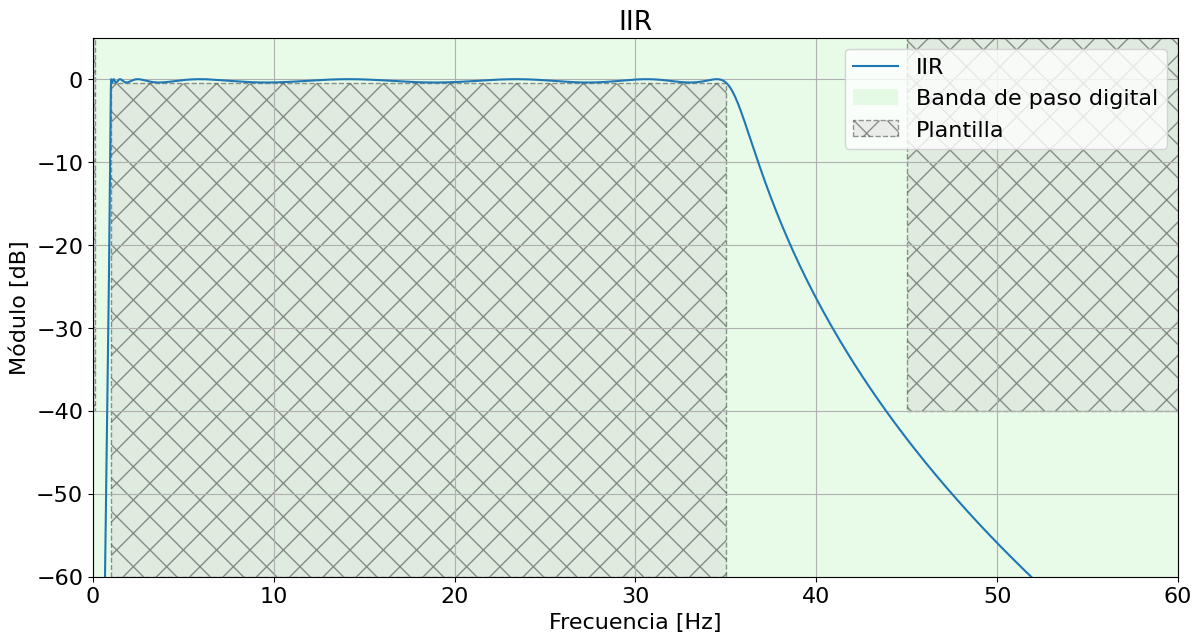

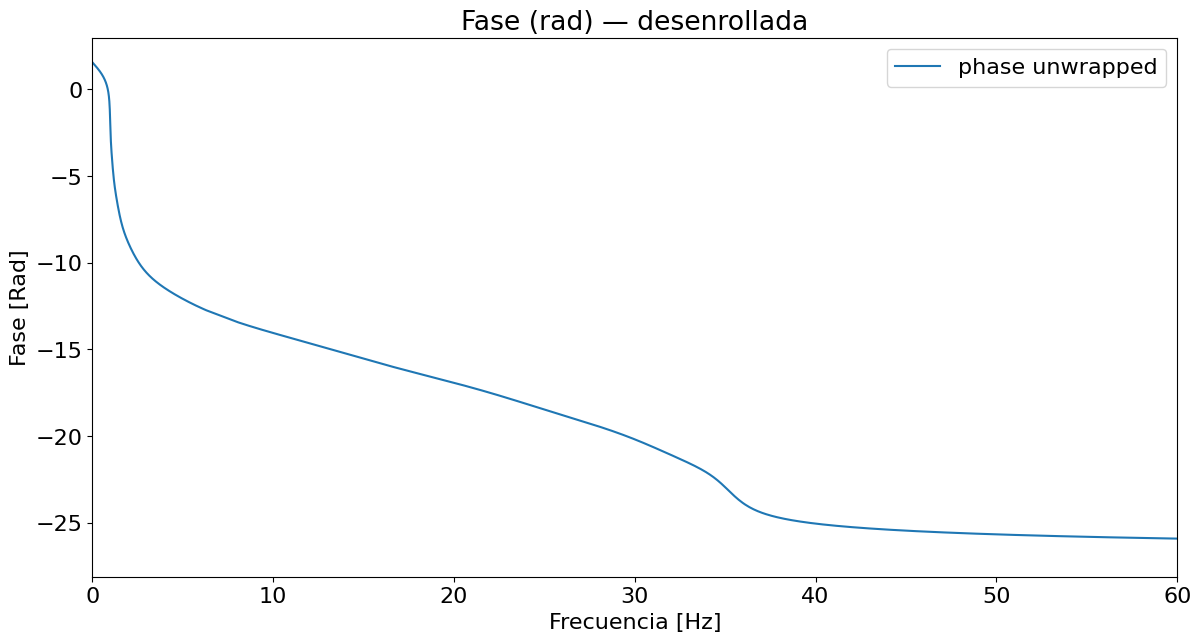

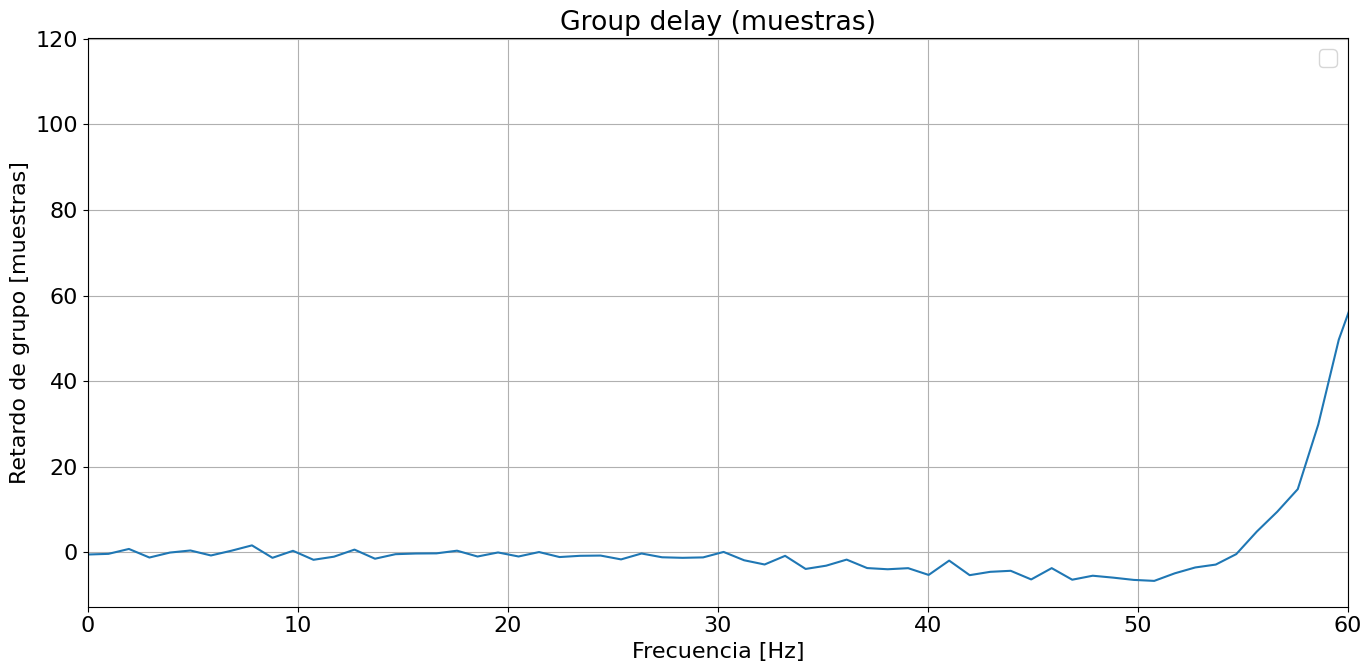

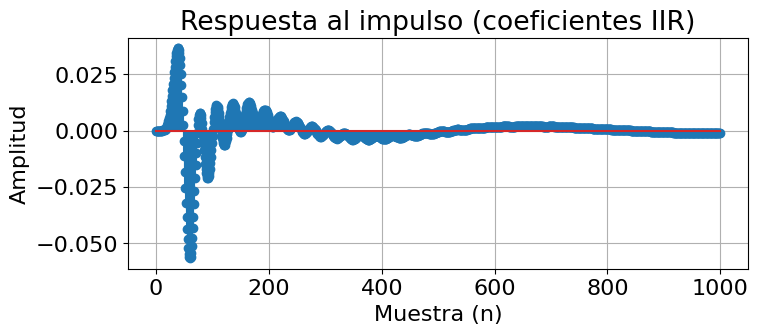

In [62]:
# Variables
ripple_iterado = 0.4 # dB
atenuacion_iterado = 40 # dB

sos_iir = sig.iirdesign(wp=[wp1,wp2],ws=[ws1,ws2],gpass=ripple_iterado, gstop=atenuacion_iterado, output='sos', analog=False, ftype='cheby1', fs = fs)

w_rad  = np.append(np.logspace(-3, 0.8, 1000), np.logspace(0.9, 1.8, 1000) )
w_rad  = np.append(w_rad, np.linspace(64, nyq_frec, 1000, endpoint=True) )

w_rad, h_iir = sig.freqz_sos(sos_iir, worN=w_rad, fs = fs)

phase = np.angle(h_iir)
phase_unwrapped = np.unwrap(phase)

#%matplotlib qt

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w_rad, 20*np.log10(np.abs(h_iir)+1e-12), label = 'IIR' )

plt.title('IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)
_ = axes_hdl.legend()
plt.show()

b_iir, a_iir = sig.sos2tf(sos_iir)  # convierte SOS a b, a
w_gd, gd = sig.group_delay((b_iir, a_iir), fs=fs)

mag_db = 20 * np.log10(abs(h_iir))

phase = np.angle(h_iir)
phase_unwrapped = np.unwrap(phase)

pb_idx = np.where(mag_db > -40)[0]
if pb_idx.size > 10:
    # ajustar fase_unwrapped vs frecuencia (Hz): phase = -2*pi*f*delay + const
    p = np.polyfit(w_rad[pb_idx], phase_unwrapped[pb_idx], 1)
    slope = p[0]
    est_delay_from_phase = -slope / (2 * np.pi)   # en muestras
else:
    est_delay_from_phase = np.nan

imp = np.zeros(1000)  # tamaño deseado
imp[0] = 1.0
h_iir_imp = sig.sosfilt(sos_iir, imp)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.plot(w_rad, phase_unwrapped, label='phase unwrapped')
plt.title('Fase (rad) — desenrollada')

plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, min(0.5*fs, 60))
plt.ylabel('Fase [Rad]')
plt.grid()
#plt.axis([0, 60, -60, 5 ]);
plt.legend()

axes_hdl = plt.gca()
axes_hdl.legend()
plt.grid()
_ = plt.legend()
plt.show()

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.plot(w_gd, gd)
plt.title('Group delay (muestras)')
plt.xlim(0, min(0.5*fs, 60))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Retardo de grupo [muestras]')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#axes_hdl = plt.gca()
#axes_hdl.legend()
# plt.grid()
# _ = plt.legend()

# Impulso (stem)
plt.figure(figsize=(8,3))
plt.stem(h_iir_imp)
plt.title('Respuesta al impulso (coeficientes IIR)')
plt.xlabel("Muestra (n)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

#### El filtro diseñado IIR cumple con la plantilla, pero se observa la alinealidad de la respuesta en fase

### Diseño del filtro FIR:

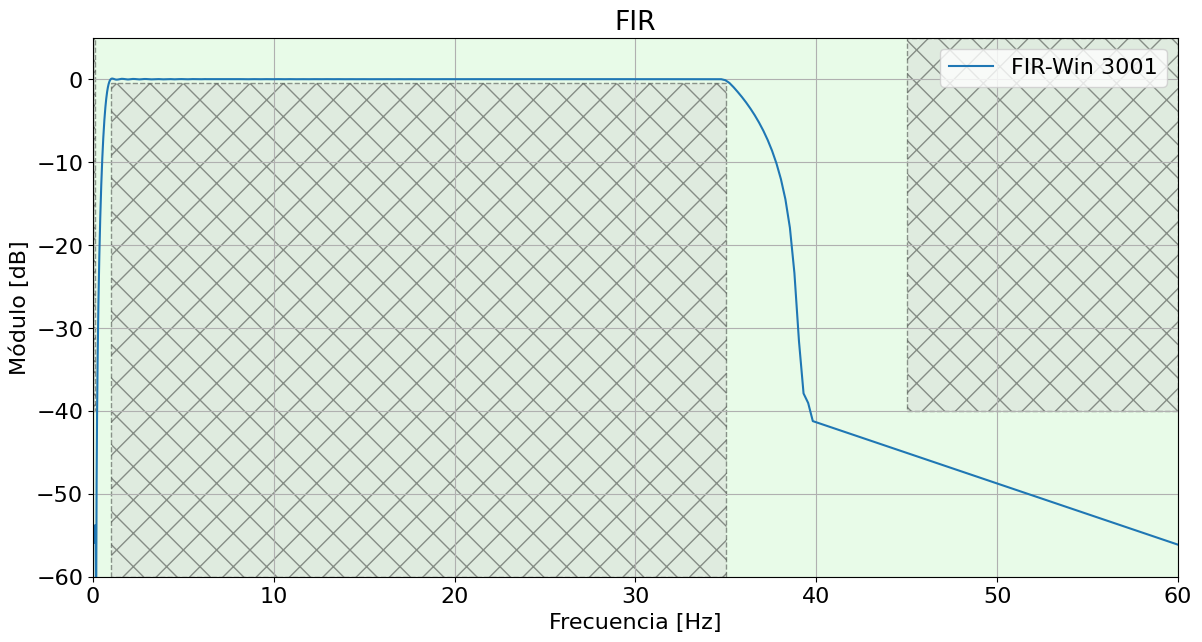

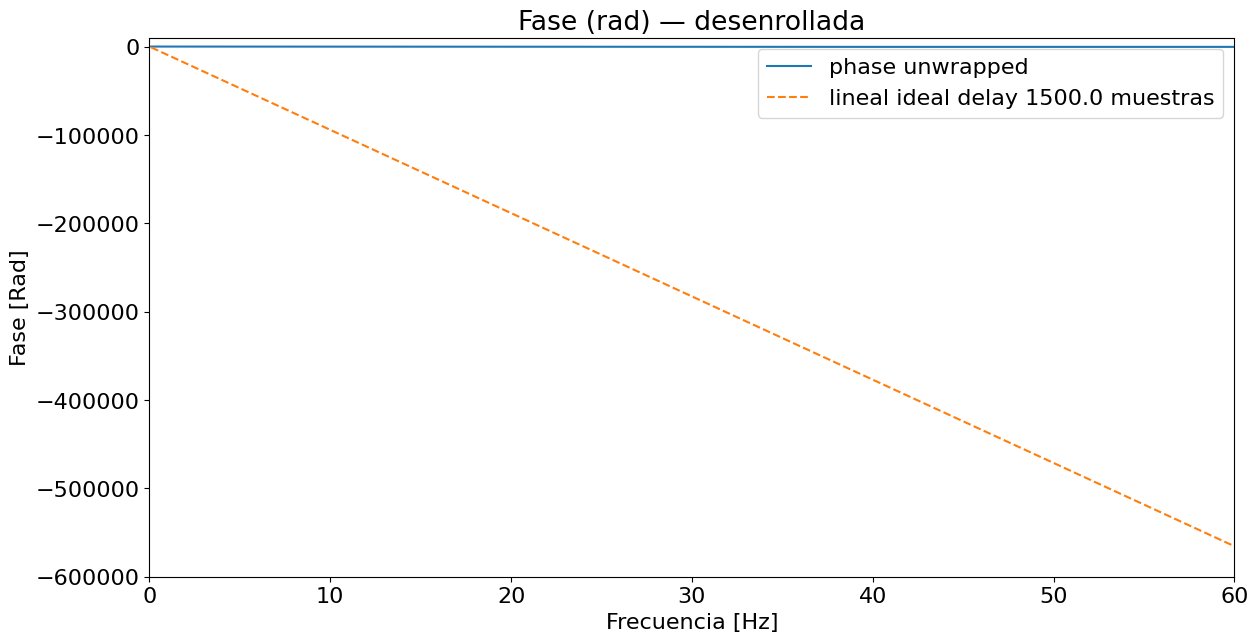

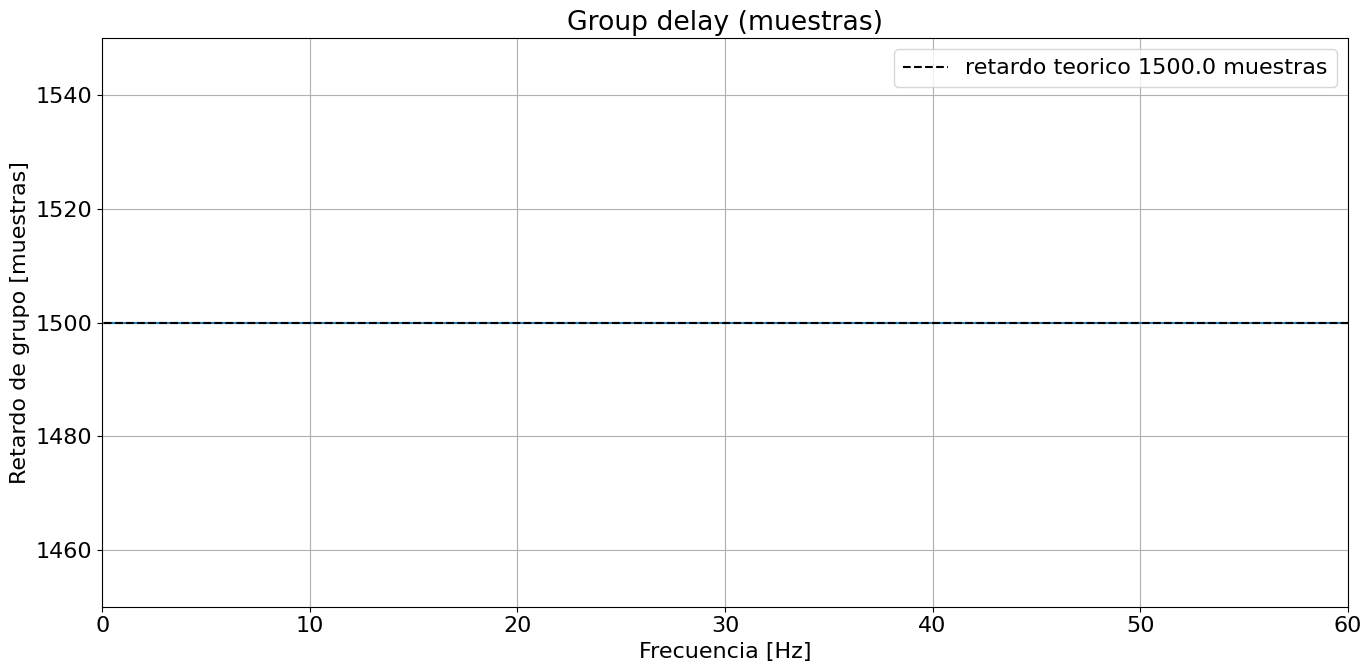

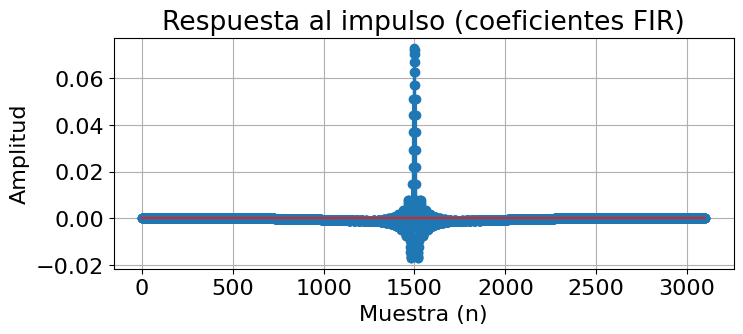

In [65]:
# plt.close('all')

# se fija una cantidad de coeficientes para la respuesta del FIR
cant_coeficientes = 3001 # 1501 default

# variables

# default: wp1=.1Hz , ws1=1Hz , wp2=35Hz , ws2=45Hz

ws1_fir = 0.1
wp1_fir = 0.5
ws2_fir = 0.7
wp2_fir = 1 
wp3_fir = 35 
ws3_fir = 39
wp4_fir = 41
ws4_fir = 45

freqs = [ws1_fir, wp1_fir, ws2_fir, wp2_fir, wp3_fir, ws3_fir, wp4_fir, ws4_fir]

frecuencias = [0, ws1_fir, wp1_fir, ws2_fir, wp2_fir, wp3_fir, ws3_fir, wp4_fir, ws4_fir, nyq_frec]

ganancia = [0, 0, 0.01, 1, 1, 1, 0.015, 0, 0, 0]

#ventana = ('chebwin', 80)

#ventana = 'bohman'

#ventana = 'blackman'

#ventana = 'cosine'

#ventana = 'taylor'

ventana = ('kaiser', 2.9)

#ventana = 'hamming'

# algoritmo de diseño, se obtienen los coeficientes del numerador
num_win = sig.firwin2(cant_coeficientes, freq = frecuencias, gain = ganancia , window= ventana , fs = fs )
# default window = 'blackmanharris' ^^

# coeficientes del denominador
den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) )

_, hh_win = sig.freqz(num_win, den, w, fs = fs)

w_gd, gd = sig.group_delay((num_win, den), w=w, fs=fs)  # gd en muestras
retardo_teorico = (cant_coeficientes - 1) / 2

mag_db = 20 * np.log10(abs(hh_win))

phase = np.angle(hh_win)
phase_unwrapped = np.unwrap(phase)

pb_idx = np.where(mag_db > -40)[0]
if pb_idx.size > 10:
    # ajustar fase_unwrapped vs frecuencia (Hz): phase = -2*pi*f*delay + const
    p = np.polyfit(w[pb_idx], phase_unwrapped[pb_idx], 1)
    slope = p[0]
    est_delay_from_phase = -slope / (2 * np.pi)   # en muestras
else:
    est_delay_from_phase = np.nan

delta = np.zeros(len(num_win) + 100)  # padding opcional
delta[0] = 1.0
h_from_filter = sig.lfilter(num_win, den, delta)  # debería coincidir con num_win (al inicio)


plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)
plt.show()

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.plot(w, phase_unwrapped, label='phase unwrapped')
plt.plot(w, -2*np.pi*w*retardo_teorico, '--', label=f'lineal ideal delay {(retardo_teorico):.1f} muestras')
plt.title('Fase (rad) — desenrollada')

plt.xlim(0, min(0.5*fs, 60))
plt.ylim(-600000, 10000)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [Rad]')
plt.grid()
#plt.axis([0, 60, -60, 5 ]);
plt.legend()

axes_hdl = plt.gca()
axes_hdl.legend()
plt.grid()
_ = plt.legend()
plt.show()

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.plot(w_gd, gd)
plt.hlines(retardo_teorico, xmin=w_gd.min(), xmax=w_gd.max(), colors='k',
           linestyles='--', label=f'retardo teorico {(retardo_teorico):.1f} muestras')
plt.title('Group delay (muestras)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Retardo de grupo [muestras]')

plt.xlim(0, min(0.5*fs, 60))
plt.ylim(max(0, retardo_teorico-50), retardo_teorico+50)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#axes_hdl = plt.gca()
#axes_hdl.legend()
# plt.grid()
# _ = plt.legend()

# Impulso (stem)
plt.figure(figsize=(8,3))
#plt.stem(np.arange(len(num_win)), num_win)
plt.stem(h_from_filter)

plt.title('Respuesta al impulso (coeficientes FIR)')
plt.xlabel("Muestra (n)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Imprime valores útiles
#print(f"retardo_teorico = {(retardo_teorico):.3f} muestras")
#print(f"retardo_estimado_por_group_delay (media passband) = {np.nanmean(gd[pb_idx]):.3f} muestras" if pb_idx.size>0 else "gd no calculable")
#print(f"retardo_estimado_por_fit_de_fase = {est_delay_from_phase:.3f} muestras")

#### El filtro FIR también cumple la plantilla, pero esta vez tendremos una respuesta en fase lineal, aunque con un mayor número de coeficientes. También se iteró con varias ventanas para hallar un mejor equilibrio entre cantidad de coeficientes y fidelidad ante la plantilla.

### Utilización de los filtros:

#### Inyectaremos el filtro FIR diseñado a una señal premeritada para juzgar su funcionamiento

In [5]:
# plt.close('all')

# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

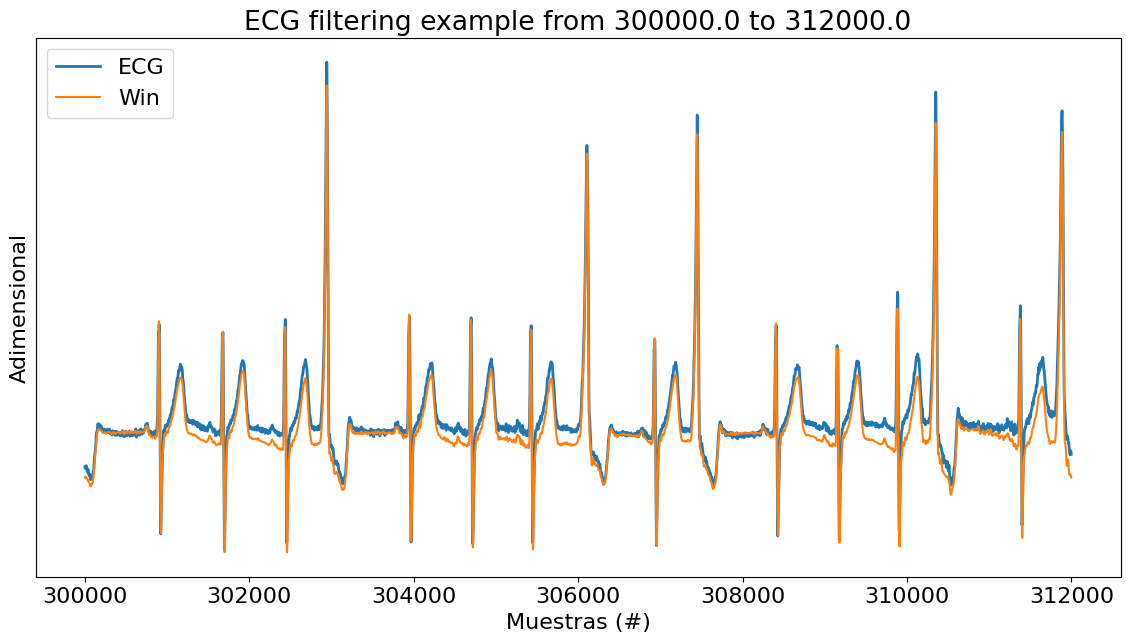

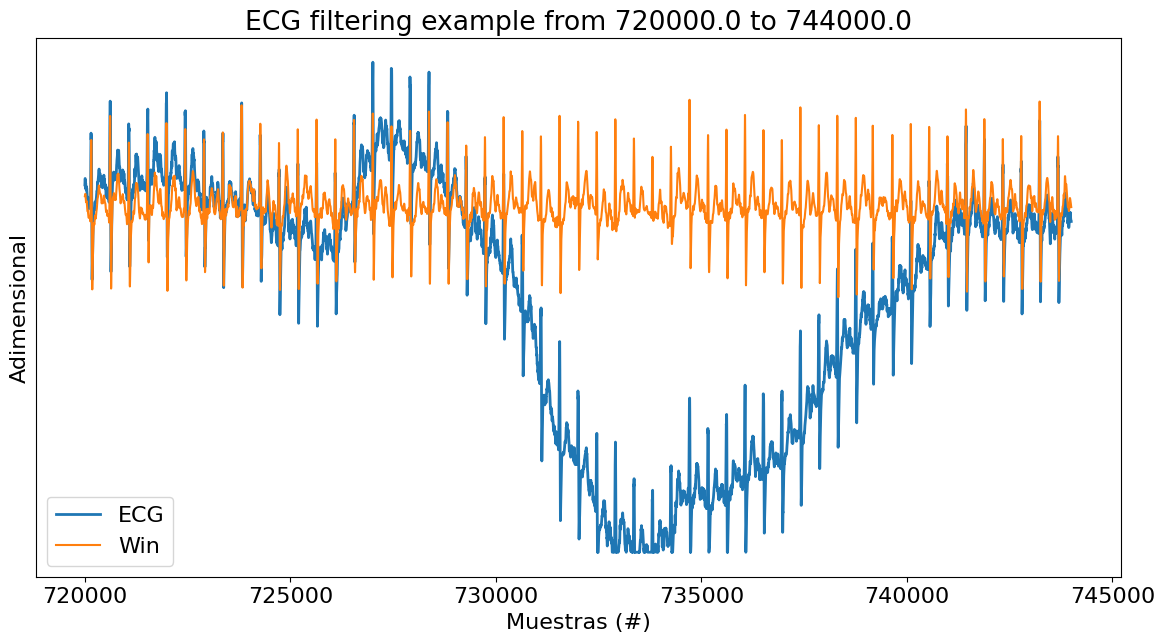

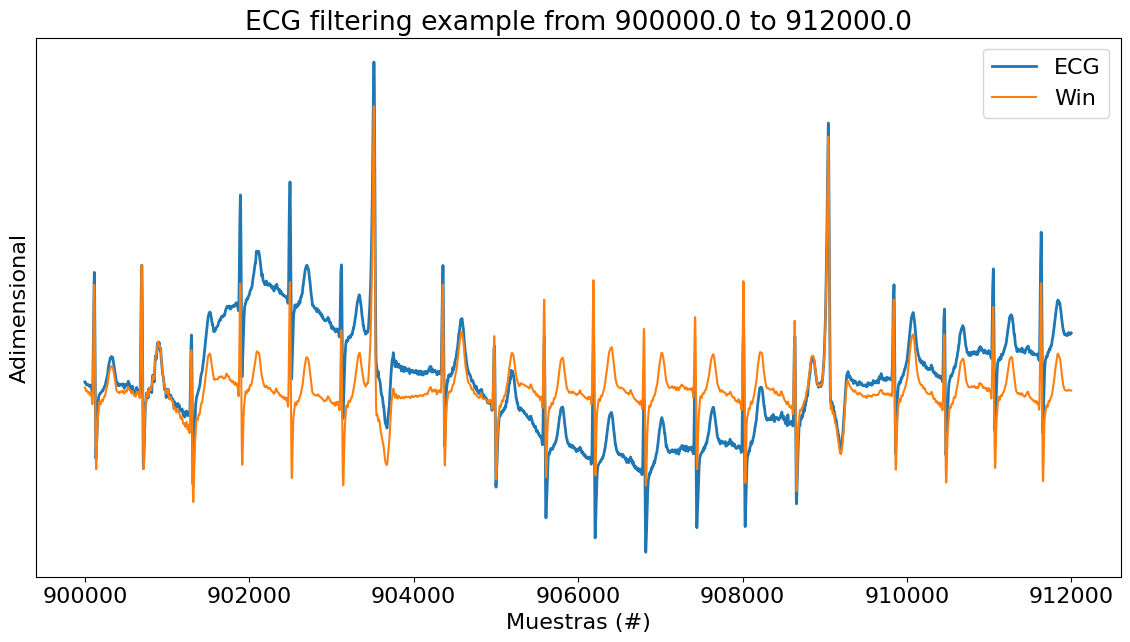

In [6]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 1500 # default 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Los resultados muestran una gran disminución de los ruidos de entrada por baja frecuencia

### Poca contaminación:

#### Analizamos la respuesta ante excitaciones que carecen de contaminación o que contienen muy poca contaminación, con el fin de analizar qué tan bien "sigue" a la señal original.

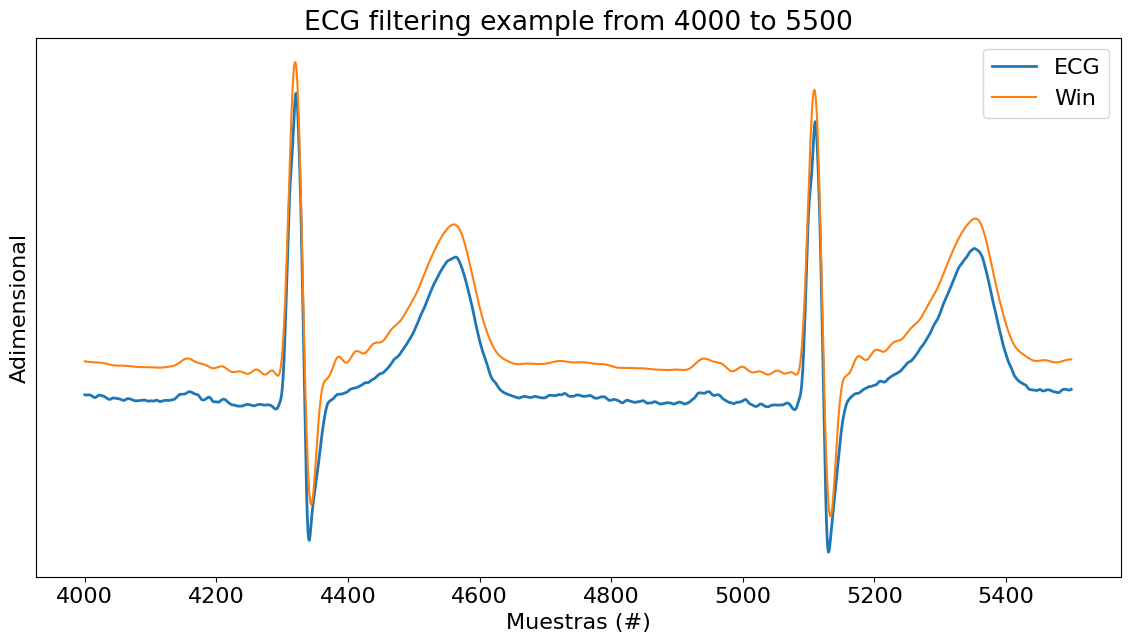

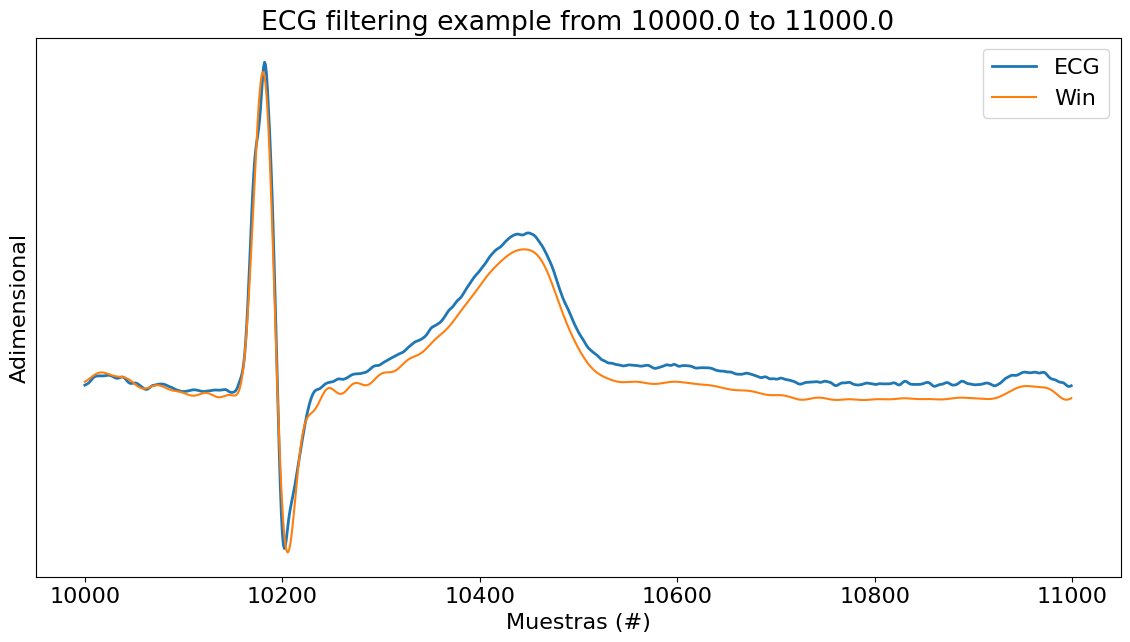

In [7]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### El filtro pareciera agregar imperfecciones en forma de ondulaciones sobre la señal original que no estaban originalmente

### Técnica filtrado bidireccional:

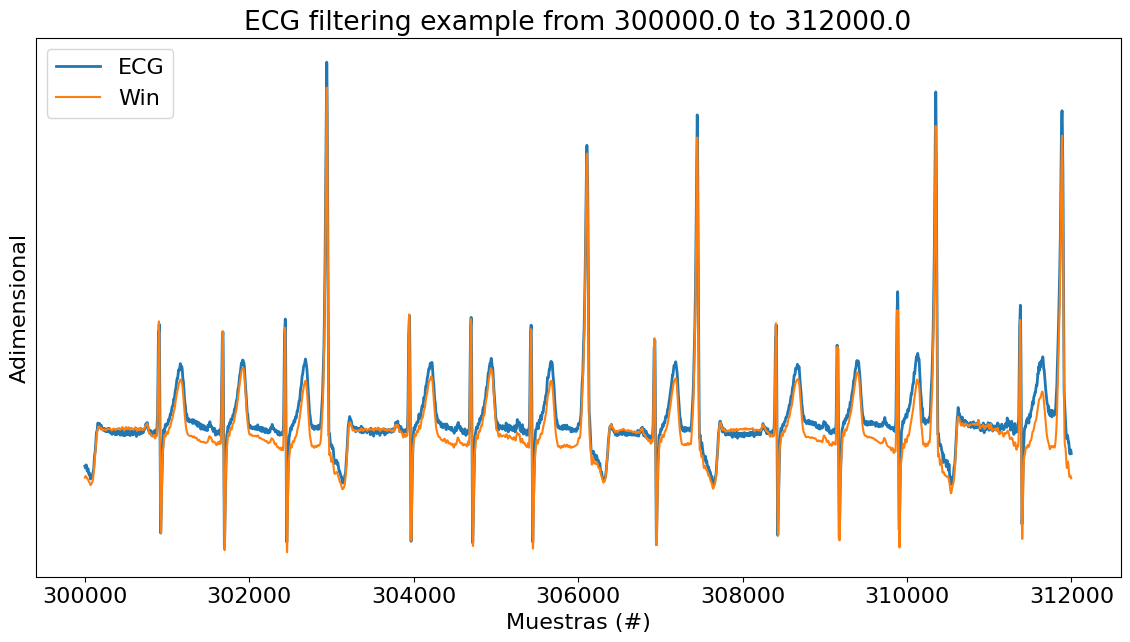

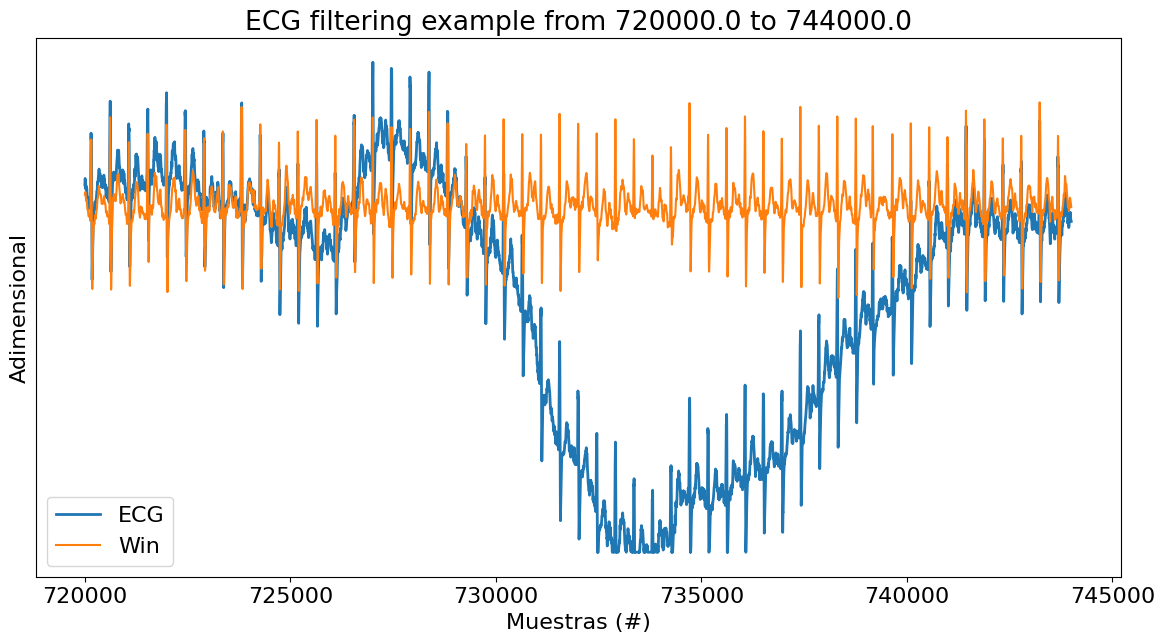

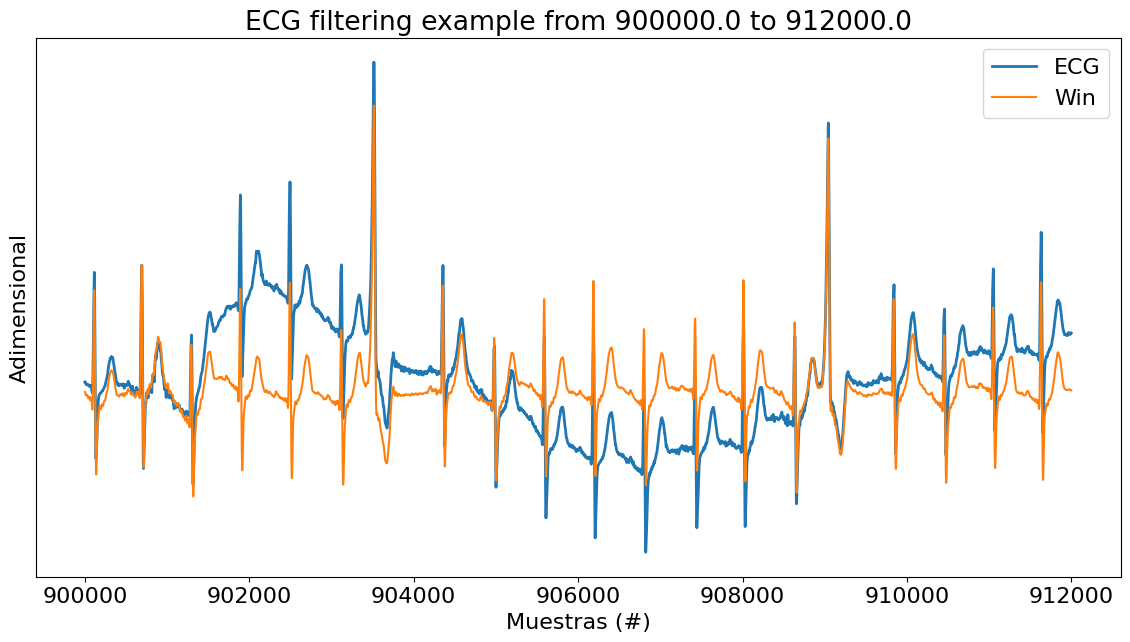

In [8]:
# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

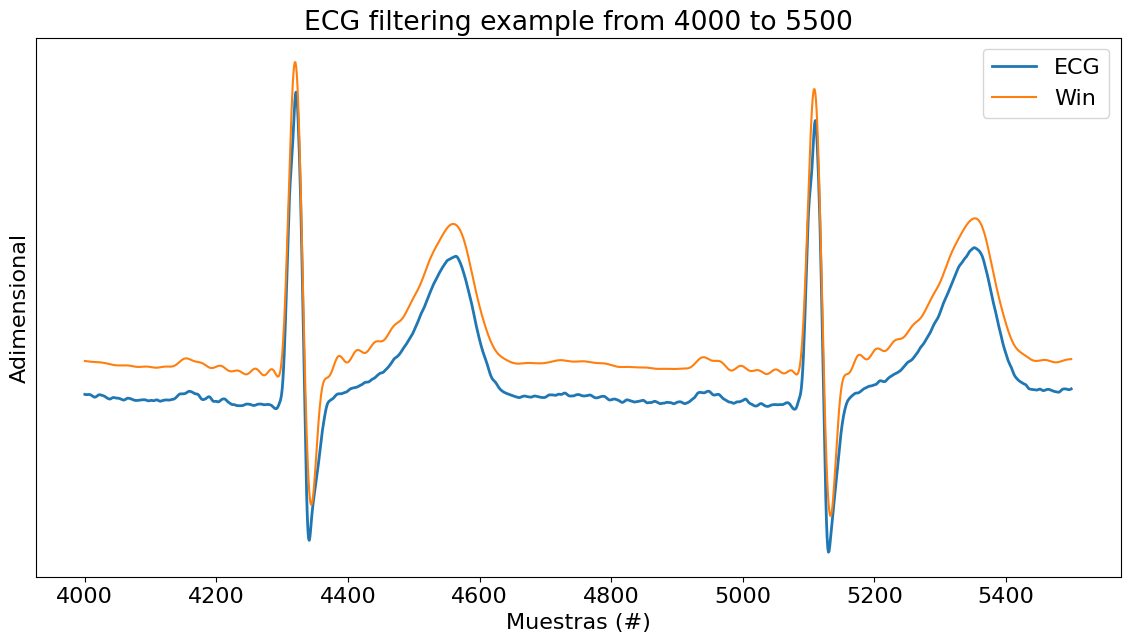

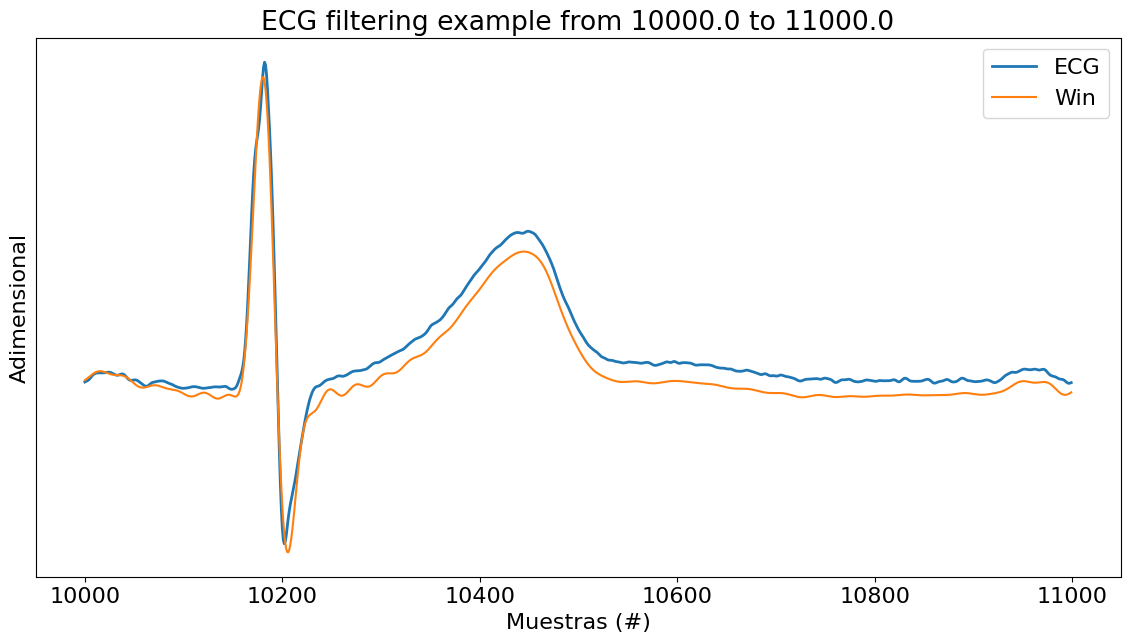

In [9]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### La técnica de filtrado bidireccional pareciera tener mayor impacto positivo en la señal ruidosa VS la señal con poca contaminación

### Exporto el filtro para utilizar en el laboratorio:

In [18]:
print(num_win)  # lista completa de coeficientes

[2.32327668e-05 2.34341999e-05 2.36256000e-05 ... 2.36256000e-05
 2.34341999e-05 2.32327668e-05]


In [19]:
# Exportar coeficientes FIR a un array en formato C

# nombre del array
array_name = "fir_coeffs"

# cantidad de coeficientes
N = len(num_win)

# abrimos un archivo o lo mostramos por pantalla
with open("fir_coeffs.h", "w") as f:
    f.write(f"// FIR filter coefficients ({N} taps)\n")
    f.write(f"// Generated by Python/scipy\n\n")
    f.write(f"#define NUM_TAPS {N}\n\n")
    f.write(f"float {array_name}[NUM_TAPS] = {{\n")
    for i, c in enumerate(num_win):
        # formato en notación científica con sufijo f (para float en C)
        f.write(f"    {c:.8e}f")
        if i < N-1:
            f.write(",\n")
        else:
            f.write("\n")
    f.write("};\n")